In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from noise_scheduler import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding


from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

import json

from sklearn.metrics import classification_report, roc_curve, auc

import seaborn as sns

#===========================

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from noise_scheduler import PinkNoiseScheduler

# Results 

## WSD107

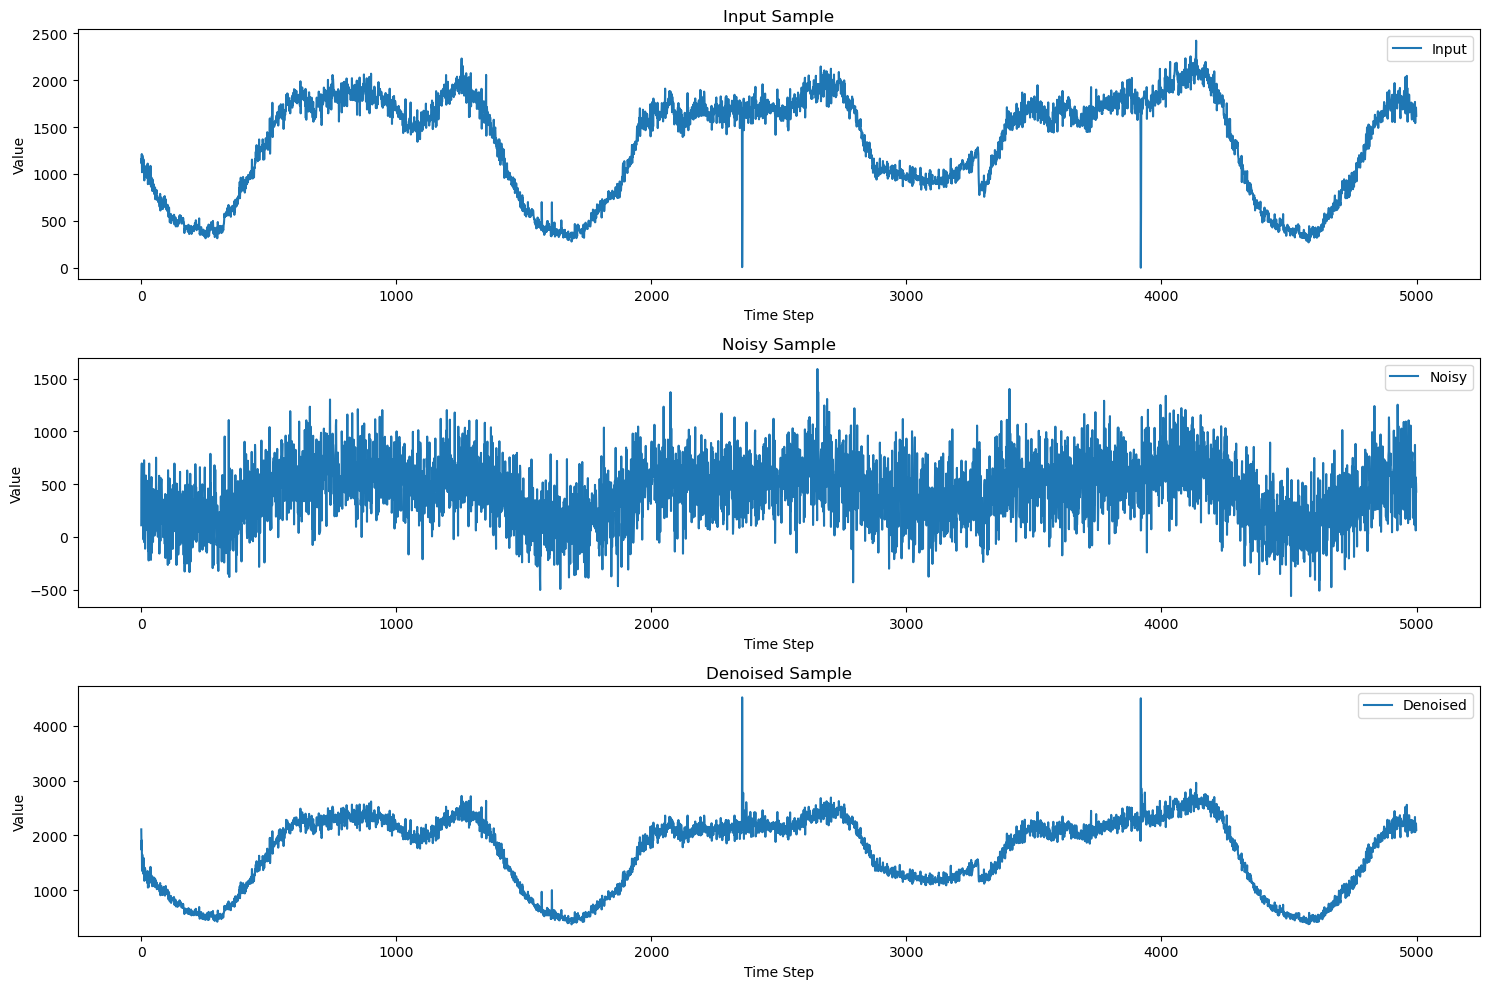
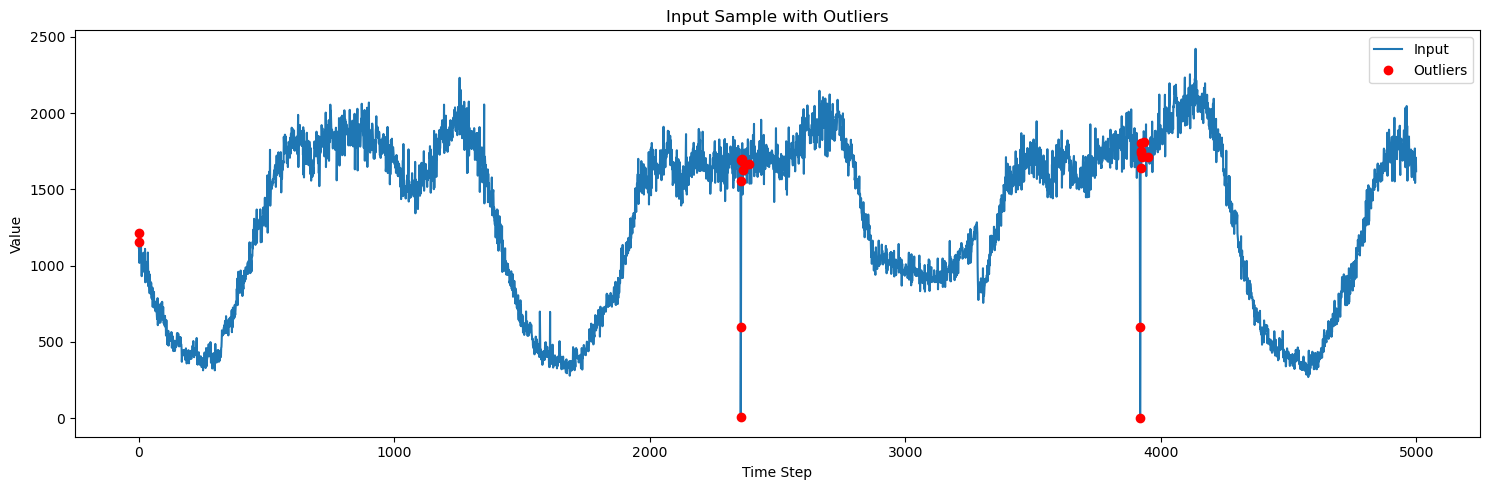

eval timesteps tensor([467, 800, 175,  81, 682, 991, 817, 240, 638, 970, 610, 752, 219, 332,
        400,  91])
Best threshold: tensor(686.2314)
Best F1 score: 0.48148148148148145
Best AUPRC score: 0.25272941176470587
Best Precision score: 0.65
Best Recall score: 0.38235294117647056
Best threshold: tensor(686.2314)
Best F1 score: 0.43478260869565216
Best AUPRC score: 0.2188654064272212
Best Precision score: 0.6521739130434783
Best Recall score: 0.32608695652173914
Best threshold: tensor(686.2314)
Best F1 score: 0.379746835443038
Best AUPRC score: 0.18288944099378884
Best Precision score: 0.6521739130434783
Best Recall score: 0.26785714285714285
Best threshold: tensor(686.2314)
Best F1 score: 0.39473684210526316
Best AUPRC score: 0.20909285714285716
Best Precision score: 0.75
Best Recall score: 0.26785714285714285
Best threshold: tensor(686.2314)
Best F1 score: 0.38571428571428573
Best AUPRC score: 0.18638522727272727
Best Precision score: 0.6136363636363636
Best Recall score: 0.28125
Best threshold: tensor(686.2314)
Best F1 score: 0.37142857142857144
Best AUPRC score: 0.17192865497076024
Best Precision score: 0.5777777777777777
Best Recall score: 0.2736842105263158
Best threshold: tensor(580.6574)
Best F1 score: 0.39
Best AUPRC score: 0.16368120300751882
Best Precision score: 0.37142857142857144
Best Recall score: 0.4105263157894737
Best threshold: tensor(686.2314)
Best F1 score: 0.3950617283950617
Best AUPRC score: 0.1907829903978052
Best Precision score: 0.5925925925925926
Best Recall score: 0.2962962962962963
Best threshold: tensor(791.8055)
Best F1 score: 0.3508771929824561
Best AUPRC score: 0.17153015873015873
Best Precision score: 0.6666666666666666
Best Recall score: 0.23809523809523808
Best threshold: tensor(580.6574)
Best F1 score: 0.4528301886792453
Best AUPRC score: 0.21531428571428568
Best Precision score: 0.48
Best Recall score: 0.42857142857142855
Best threshold: tensor(686.2314)
Best F1 score: 0.3875968992248062
Best AUPRC score: 0.17714391534391535
Best Precision score: 0.5555555555555556
Best Recall score: 0.2976190476190476
Best threshold: tensor(686.2314)
Best F1 score: 0.3902439024390244
Best AUPRC score: 0.1664627450980392
Best Precision score: 0.47058823529411764
Best Recall score: 0.3333333333333333
Best threshold: tensor(580.6574)
Best F1 score: 0.4626865671641791
Best AUPRC score: 0.2214777777777778
Best Precision score: 0.4305555555555556
Best Recall score: 0.5
Best threshold: tensor(791.8055)
Best F1 score: 0.4485981308411215
Best AUPRC score: 0.23817142857142856
Best Precision score: 0.6857142857142857
Best Recall score: 0.3333333333333333
Best threshold: tensor(791.8055)
Best F1 score: 0.49056603773584906
Best AUPRC score: 0.25528809523809526
Best Precision score: 0.6190476190476191
Best Recall score: 0.40625
Best threshold: tensor(791.8055)
Best F1 score: 0.5454545454545454
Best AUPRC score: 0.3549739130434783
Best Precision score: 0.9
Best Recall score: 0.391304347826087
F1 score: 0.4226128636115364
AUPRC score: 0.21104484446841024
Precision score: 0.6042444405847539
Recall score: 0.33965110842519053

## NAB "../datasets/UTS/NAB/Twitter_volume_CVS"

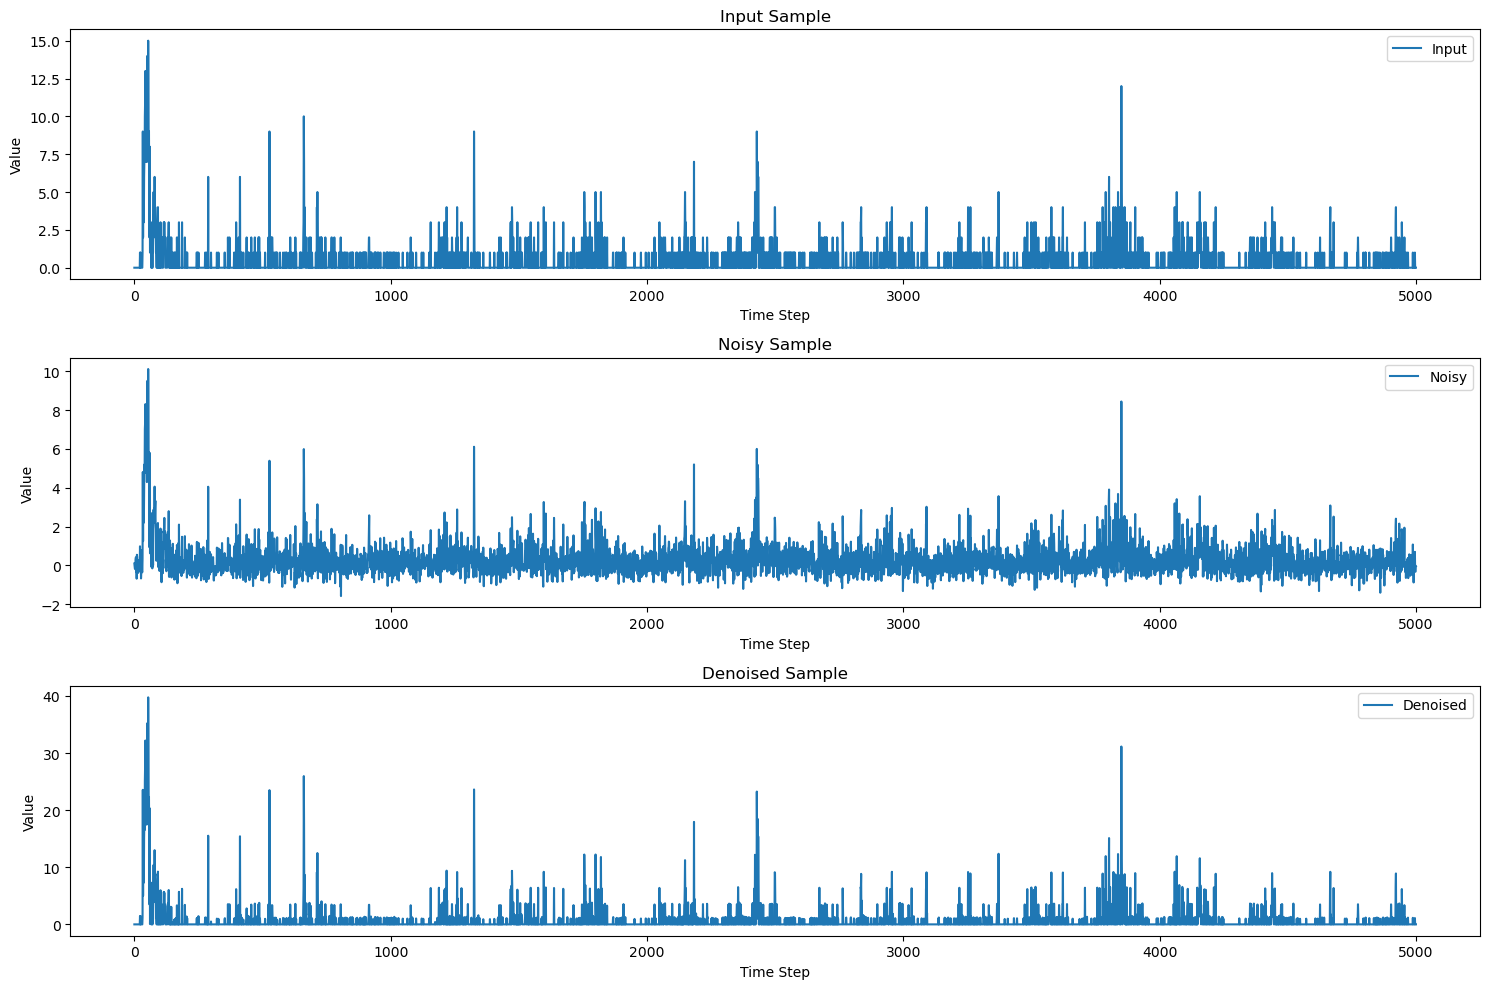
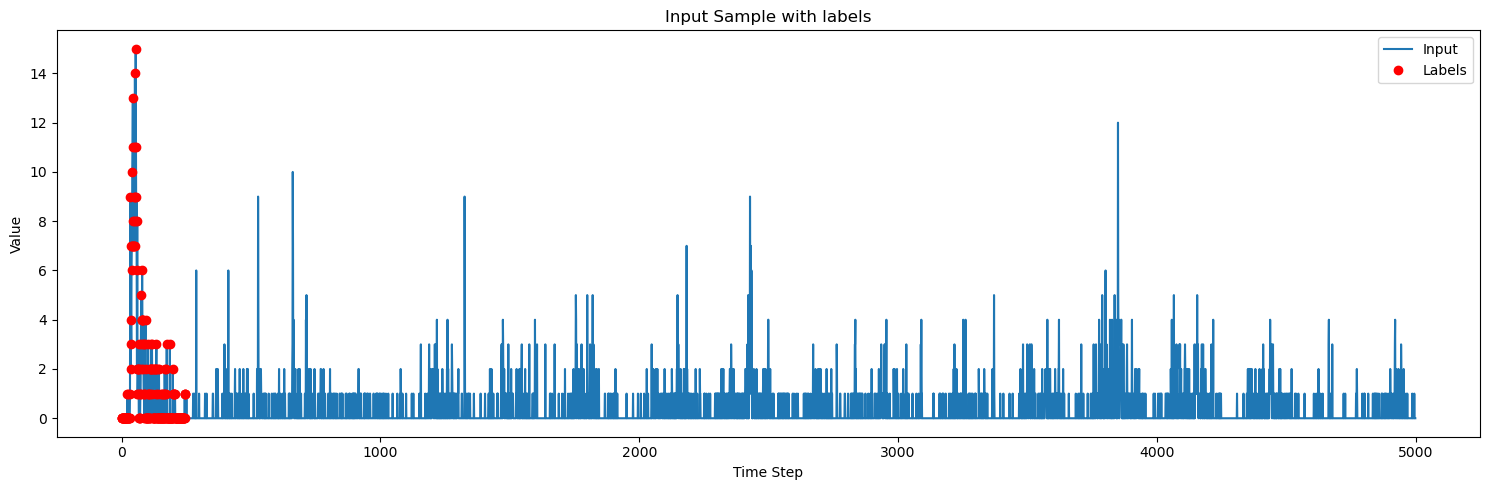
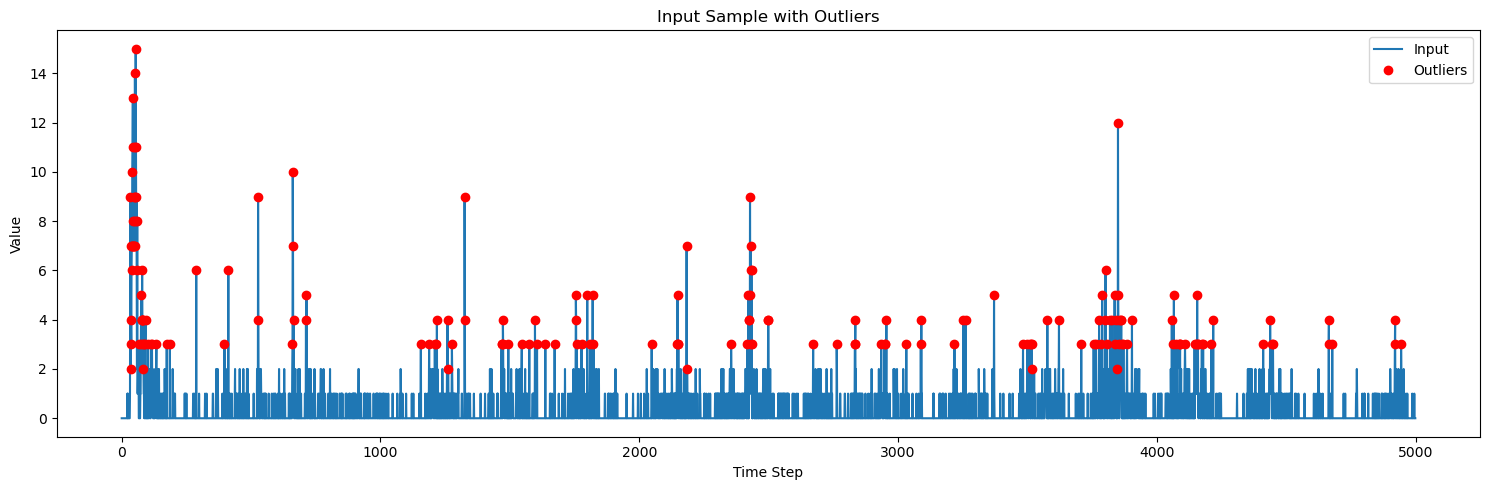

eval timesteps tensor([866, 361, 790, 296])
Best threshold: tensor(2.3182)
Best F1 score: 0.21809744779582366
Best AUPRC score: 0.08860499911987327
Best Precision score: 0.2554347826086957
Best Recall score: 0.1902834008097166
Best threshold: tensor(1.2143)
Best F1 score: 0.027649769585253458
Best AUPRC score: 0.015509614754992906
Best Precision score: 0.01680672268907563
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.7727)
Best F1 score: 0.12422360248447205
Best AUPRC score: 0.08503343251885967
Best Precision score: 0.12285012285012285
Best Recall score: 0.12562814070351758
Best threshold: tensor(0.7727)
Best F1 score: 0.12195121951219512
Best AUPRC score: 0.08448485079425565
Best Precision score: 0.11848341232227488
Best Recall score: 0.12562814070351758
F1 score: 0.12298050984443606
AUPRC score: 0.06840822429699538
Precision score: 0.12839376011754228
Recall score: 0.1298654400347074

# Complete Evaluation

In [5]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [6]:
# training testing imports 
import train_test_fonctions
from train_test_fonctions import calculate_f1_auprc_score, plot_samples, plot_predictions, trainer, tester, train_tracker, z_score_outliers, modified_z_score_outliers, iqr_outliers, iqr_collective_outliers
from train_test_fonctions import train_model, test_model, process_directory, trainer_all_in_one

## WSD dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [ ]:
import os

data_folder = "../datasets/UTS/WSD"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


# NAB dataset - all in one 

Change the output folder name ! 

In [9]:
# config for NAB dataset
base_config = {
  "data_path":  "../datasets/UTS/NAB",
  "output_dir": "output_NAB_pink1",
  "train_batch_size": 2,
  "eval_batch_size": 1,
  "num_epochs": 15,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.3,
  "save_model_epochs": 1
}

sequence_length = 3000
input_size = 1  # Assuming 1D time series data
stride = 100


In [10]:
# all in one training and testing
import os
    
config = Config(base_config)

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32,64, 128, 256,128,64,32,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = "../datasets/UTS/NAB"

#================================================================================================
# train the model and test it

model, losses = trainer_all_in_one(sequence_length, stride, base_config, config, model, noise_scheduler, data_folder)


Training model...


  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': 52676.61328125, 'epoch': 0}
{'loss': 2458.279052734375, 'epoch': 0}
{'loss': 38.27217483520508, 'epoch': 0}
{'loss': 0.8504834175109863, 'epoch': 0}
{'loss': 597.2357177734375, 'epoch': 0}
{'loss': 196.02423095703125, 'epoch': 0}
{'loss': 19.194808959960938, 'epoch': 0}
{'loss': 465.4102783203125, 'epoch': 0}
{'loss': 1.7044597864151, 'epoch': 0}


  7%|▋         | 1/15 [00:21<05:07, 21.98s/it]

{'loss': 38.97718048095703, 'epoch': 0}
{'loss': 61038.62890625, 'epoch': 1}
{'loss': 4643.0908203125, 'epoch': 1}
{'loss': 23.895713806152344, 'epoch': 1}
{'loss': 0.7205836772918701, 'epoch': 1}
{'loss': 636.2485961914062, 'epoch': 1}
{'loss': 341.659912109375, 'epoch': 1}
{'loss': 13.683022499084473, 'epoch': 1}
{'loss': 508.2615966796875, 'epoch': 1}
{'loss': 5.4445695877075195, 'epoch': 1}


 13%|█▎        | 2/15 [00:43<04:45, 21.96s/it]

{'loss': 211.67713928222656, 'epoch': 1}
{'loss': 36326.859375, 'epoch': 2}
{'loss': 1167.0523681640625, 'epoch': 2}
{'loss': 67.35453796386719, 'epoch': 2}
{'loss': 0.8709304332733154, 'epoch': 2}
{'loss': 694.5787353515625, 'epoch': 2}
{'loss': 417.3219909667969, 'epoch': 2}
{'loss': 21.570484161376953, 'epoch': 2}
{'loss': 165.7046661376953, 'epoch': 2}
{'loss': 2.254718542098999, 'epoch': 2}


 20%|██        | 3/15 [01:05<04:23, 21.93s/it]

{'loss': 51.465511322021484, 'epoch': 2}
{'loss': 55425.94140625, 'epoch': 3}
{'loss': 1570.6190185546875, 'epoch': 3}
{'loss': 47.94306945800781, 'epoch': 3}
{'loss': 0.8612579703330994, 'epoch': 3}
{'loss': 653.6190185546875, 'epoch': 3}
{'loss': 1537.9376220703125, 'epoch': 3}
{'loss': 21.331392288208008, 'epoch': 3}
{'loss': 379.2572021484375, 'epoch': 3}
{'loss': 5.44746732711792, 'epoch': 3}


 27%|██▋       | 4/15 [01:27<04:01, 21.91s/it]

{'loss': 105.30485534667969, 'epoch': 3}
{'loss': 12692.2734375, 'epoch': 4}
{'loss': 2400.357666015625, 'epoch': 4}
{'loss': 34.98942184448242, 'epoch': 4}
{'loss': 0.6538851857185364, 'epoch': 4}
{'loss': 533.3163452148438, 'epoch': 4}
{'loss': 279.2249450683594, 'epoch': 4}
{'loss': 19.677839279174805, 'epoch': 4}
{'loss': 457.60809326171875, 'epoch': 4}
{'loss': 3.9075706005096436, 'epoch': 4}


 33%|███▎      | 5/15 [01:49<03:39, 21.98s/it]

{'loss': 155.68475341796875, 'epoch': 4}
{'loss': 56630.453125, 'epoch': 5}
{'loss': 5752.4453125, 'epoch': 5}
{'loss': 51.032405853271484, 'epoch': 5}
{'loss': 1.415034294128418, 'epoch': 5}
{'loss': 426.7699890136719, 'epoch': 5}
{'loss': 509.72808837890625, 'epoch': 5}
{'loss': 19.040607452392578, 'epoch': 5}
{'loss': 726.2603149414062, 'epoch': 5}
{'loss': 3.703589916229248, 'epoch': 5}


 40%|████      | 6/15 [02:11<03:18, 22.02s/it]

{'loss': 209.16641235351562, 'epoch': 5}
{'loss': 60509.30859375, 'epoch': 6}
{'loss': 1682.939453125, 'epoch': 6}
{'loss': 35.13642883300781, 'epoch': 6}
{'loss': 1.25531005859375, 'epoch': 6}
{'loss': 633.926513671875, 'epoch': 6}
{'loss': 531.9537353515625, 'epoch': 6}
{'loss': 22.67775535583496, 'epoch': 6}
{'loss': 482.44525146484375, 'epoch': 6}
{'loss': 5.996304035186768, 'epoch': 6}


 47%|████▋     | 7/15 [02:34<02:57, 22.25s/it]

{'loss': 67.37020874023438, 'epoch': 6}
{'loss': 46912.6328125, 'epoch': 7}
{'loss': 2632.487548828125, 'epoch': 7}
{'loss': 48.34075164794922, 'epoch': 7}
{'loss': 2.6404032707214355, 'epoch': 7}
{'loss': 588.7855224609375, 'epoch': 7}
{'loss': 562.8895263671875, 'epoch': 7}
{'loss': 24.36162567138672, 'epoch': 7}
{'loss': 527.640869140625, 'epoch': 7}
{'loss': 6.021249294281006, 'epoch': 7}


 53%|█████▎    | 8/15 [02:56<02:35, 22.20s/it]

{'loss': 215.70289611816406, 'epoch': 7}
{'loss': 43623.375, 'epoch': 8}
{'loss': 708.9293212890625, 'epoch': 8}
{'loss': 21.735260009765625, 'epoch': 8}
{'loss': 1.1153217554092407, 'epoch': 8}
{'loss': 477.677001953125, 'epoch': 8}
{'loss': 545.5315551757812, 'epoch': 8}
{'loss': 22.937055587768555, 'epoch': 8}
{'loss': 401.82354736328125, 'epoch': 8}
{'loss': 7.650651454925537, 'epoch': 8}


 60%|██████    | 9/15 [03:19<02:14, 22.37s/it]

{'loss': 284.731201171875, 'epoch': 8}
{'loss': 48987.80078125, 'epoch': 9}
{'loss': 935.0867309570312, 'epoch': 9}
{'loss': 49.08171463012695, 'epoch': 9}
{'loss': 2.439159631729126, 'epoch': 9}
{'loss': 673.8858032226562, 'epoch': 9}
{'loss': 438.39276123046875, 'epoch': 9}
{'loss': 24.226041793823242, 'epoch': 9}
{'loss': 42.83991622924805, 'epoch': 9}
{'loss': 7.484948635101318, 'epoch': 9}


 67%|██████▋   | 10/15 [03:41<01:51, 22.30s/it]

{'loss': 218.16925048828125, 'epoch': 9}
{'loss': 49737.44140625, 'epoch': 10}
{'loss': 6000.810546875, 'epoch': 10}
{'loss': 110.78877258300781, 'epoch': 10}
{'loss': 2.4527463912963867, 'epoch': 10}
{'loss': 408.1335144042969, 'epoch': 10}
{'loss': 584.2369995117188, 'epoch': 10}
{'loss': 20.360347747802734, 'epoch': 10}
{'loss': 499.2855529785156, 'epoch': 10}
{'loss': 6.00665283203125, 'epoch': 10}


 73%|███████▎  | 11/15 [04:03<01:28, 22.23s/it]

{'loss': 98.00833129882812, 'epoch': 10}
{'loss': 38338.4375, 'epoch': 11}
{'loss': 1869.1466064453125, 'epoch': 11}
{'loss': 49.34812545776367, 'epoch': 11}
{'loss': 2.322283983230591, 'epoch': 11}
{'loss': 440.07696533203125, 'epoch': 11}
{'loss': 542.9946899414062, 'epoch': 11}
{'loss': 15.235036849975586, 'epoch': 11}
{'loss': 297.24896240234375, 'epoch': 11}
{'loss': 7.795483112335205, 'epoch': 11}


 80%|████████  | 12/15 [04:26<01:06, 22.32s/it]

{'loss': 182.54039001464844, 'epoch': 11}
{'loss': 42238.6484375, 'epoch': 12}
{'loss': 4088.235595703125, 'epoch': 12}
{'loss': 50.71369934082031, 'epoch': 12}
{'loss': 3.80346941947937, 'epoch': 12}
{'loss': 418.9183654785156, 'epoch': 12}
{'loss': 427.8388366699219, 'epoch': 12}
{'loss': 15.260039329528809, 'epoch': 12}
{'loss': 338.4540710449219, 'epoch': 12}
{'loss': 4.568389415740967, 'epoch': 12}


 87%|████████▋ | 13/15 [04:48<00:44, 22.27s/it]

{'loss': 136.17660522460938, 'epoch': 12}
{'loss': 40612.5859375, 'epoch': 13}
{'loss': 2855.07177734375, 'epoch': 13}
{'loss': 50.35165023803711, 'epoch': 13}
{'loss': 3.141512155532837, 'epoch': 13}
{'loss': 708.9226684570312, 'epoch': 13}
{'loss': 87.49161529541016, 'epoch': 13}
{'loss': 20.191621780395508, 'epoch': 13}
{'loss': 433.20440673828125, 'epoch': 13}
{'loss': 7.294871807098389, 'epoch': 13}


 93%|█████████▎| 14/15 [05:10<00:22, 22.23s/it]

{'loss': 129.27427673339844, 'epoch': 13}
{'loss': 54503.92578125, 'epoch': 14}
{'loss': 1542.732666015625, 'epoch': 14}
{'loss': 42.917381286621094, 'epoch': 14}
{'loss': 3.2326648235321045, 'epoch': 14}
{'loss': 356.8515319824219, 'epoch': 14}
{'loss': 543.1912231445312, 'epoch': 14}
{'loss': 22.829421997070312, 'epoch': 14}
{'loss': 316.5768737792969, 'epoch': 14}
{'loss': 3.8579232692718506, 'epoch': 14}


100%|██████████| 15/15 [05:32<00:00, 22.16s/it]

{'loss': 215.5842742919922, 'epoch': 14}



Processing directory: Twitter_volume_AAPL
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 34.57it/s]



IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83      5602
         1.0       0.13      0.59      0.22       398

    accuracy                           0.72      6000
   macro avg       0.55      0.66      0.52      6000
weighted avg       0.91      0.72      0.79      6000

ROC AUC: 0.7160

Processing directory: Twitter_volume_AMZN
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 59.39it/s]



IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.90      0.49      0.64      5208
         1.0       0.16      0.66      0.26       792

    accuracy                           0.52      6000
   macro avg       0.53      0.58      0.45      6000
weighted avg       0.81      0.52      0.59      6000

ROC AUC: 0.6330

Processing directory: Twitter_volume_CRM
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 47.37it/s]



IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      5651
         1.0       0.23      0.48      0.31       349

    accuracy                           0.87      6000
   macro avg       0.60      0.69      0.62      6000
weighted avg       0.92      0.87      0.89      6000

ROC AUC: 0.7661

Processing directory: Twitter_volume_CVS
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 47.93it/s]



IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.88      0.19      0.31      5355
         1.0       0.11      0.79      0.19       645

    accuracy                           0.25      6000
   macro avg       0.49      0.49      0.25      6000
weighted avg       0.80      0.25      0.30      6000

ROC AUC: 0.4999

Processing directory: Twitter_volume_FB
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 46.65it/s]



IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.85      0.71      0.77      5208
         1.0       0.08      0.16      0.11       792

    accuracy                           0.64      6000
   macro avg       0.46      0.44      0.44      6000
weighted avg       0.75      0.64      0.68      6000

ROC AUC: 0.4124

Processing directory: Twitter_volume_GOOG
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 59.57it/s]



IQR outliers classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      5602
         1.0       0.22      0.88      0.35       398

    accuracy                           0.78      6000
   macro avg       0.60      0.83      0.61      6000
weighted avg       0.94      0.78      0.83      6000

ROC AUC: 0.9106

Processing directory: Twitter_volume_IBM
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 55.61it/s]
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/


IQR outliers classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      6000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.88      6000
   macro avg       0.50      0.44      0.47      6000
weighted avg       1.00      0.88      0.93      6000

ROC AUC: nan

Processing directory: Twitter_volume_KO
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 59.40it/s]



IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80      4940
         1.0       0.15      0.18      0.17      1060

    accuracy                           0.68      6000
   macro avg       0.49      0.48      0.48      6000
weighted avg       0.70      0.68      0.69      6000

ROC AUC: 0.4907

Processing directory: Twitter_volume_PFE
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 62.13it/s]



IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.93      0.67      0.78      5602
         1.0       0.06      0.28      0.09       398

    accuracy                           0.64      6000
   macro avg       0.49      0.47      0.44      6000
weighted avg       0.87      0.64      0.73      6000

ROC AUC: 0.4667

Processing directory: Twitter_volume_UPS
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 61.22it/s]



IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      5682
         1.0       0.23      0.40      0.29       318

    accuracy                           0.90      6000
   macro avg       0.60      0.66      0.62      6000
weighted avg       0.93      0.90      0.91      6000

ROC AUC: 0.6939

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.71      0.81     54850
         1.0       0.13      0.46      0.20      5150

    accuracy                           0.69     60000
   macro avg       0.53      0.58      0.50     60000
weighted avg       0.86      0.69      0.75     60000



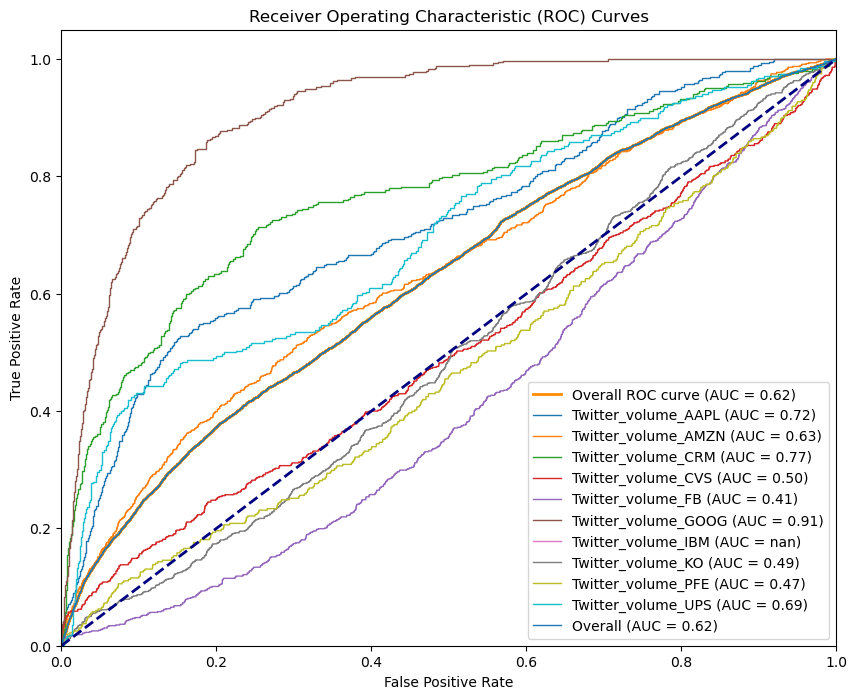


Overall ROC AUC: 0.6228


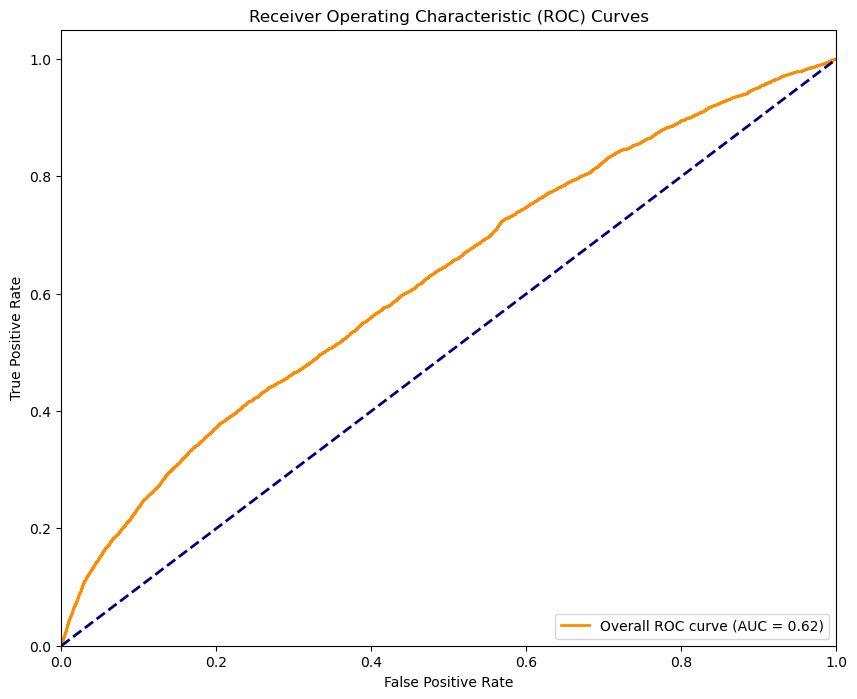

In [11]:
# evaluation with roc curve and classification report 

model.eval()
eval_batch_size = config.eval_batch_size

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        print(f"\nProcessing directory: {dir}")
    
        # change datapath in the config
        base_config["data_path"] = data_path
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length , stride=sequence_length , normalize=False)
        print("Number of batches:", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

        all_labels = []
        all_scores = []

        for step, (sample, labels) in enumerate(tqdm(test_dataloader)):
            std_data = torch.std(sample)
            
            with torch.no_grad():
                timesteps = torch.tensor([70])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                # Calculate IQR outliers
                iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
                
                labels = labels.cpu().numpy()

                # Store labels and scores
                all_labels.extend(labels.reshape(-1))
                all_scores.extend(iqr_scores.reshape(-1))

        # Calculate metrics for this directory
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        print("\nIQR outliers classification report for", dir)
        print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))
        print(f"ROC AUC: {roc_auc:.4f}")

        # Store results for this directory
        all_dir_results.append({
            'dir': dir,
            'labels': all_labels,
            'scores': all_scores,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })

# Compute overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

#save the results in a csv file
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"allinone_roc_resultsf{config.num_epochs}.csv"))

# Plot overall ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for each directory
for res in all_dir_results:
    plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_roc_curves_{config.num_epochs}.png"))
plt.show()


print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()


In [12]:
# ROC AUC score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"allin_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: nan
Median: nan
Min: nan
Max: nan


# NAB dataset - one by one 


Processing directory: Twitter_volume_AAPL


Training:   7%|▋         | 1/15 [00:02<00:34,  2.44s/it]

Epoch 1/15, Loss: 53255.3419


Training:  13%|█▎        | 2/15 [00:04<00:32,  2.49s/it]

Epoch 2/15, Loss: 76081.3401


Training:  20%|██        | 3/15 [00:07<00:28,  2.41s/it]

Epoch 3/15, Loss: 56513.1102


Training:  27%|██▋       | 4/15 [00:09<00:25,  2.30s/it]

Epoch 4/15, Loss: 65838.3641


Training:  33%|███▎      | 5/15 [00:11<00:23,  2.32s/it]

Epoch 5/15, Loss: 45940.2155


Training:  40%|████      | 6/15 [00:13<00:20,  2.28s/it]

Epoch 6/15, Loss: 126245.3634


Training:  47%|████▋     | 7/15 [00:16<00:18,  2.25s/it]

Epoch 7/15, Loss: 83173.8108


Training:  53%|█████▎    | 8/15 [00:18<00:16,  2.33s/it]

Epoch 8/15, Loss: 57665.5346


Training:  60%|██████    | 9/15 [00:20<00:13,  2.29s/it]

Epoch 9/15, Loss: 37983.4066


Training:  67%|██████▋   | 10/15 [00:23<00:11,  2.26s/it]

Epoch 10/15, Loss: 60438.6000


Training:  73%|███████▎  | 11/15 [00:25<00:08,  2.24s/it]

Epoch 11/15, Loss: 61076.9645


Training:  80%|████████  | 12/15 [00:27<00:06,  2.23s/it]

Epoch 12/15, Loss: 69578.7270


Training:  87%|████████▋ | 13/15 [00:29<00:04,  2.23s/it]

Epoch 13/15, Loss: 55513.2821


Training:  93%|█████████▎| 14/15 [00:31<00:02,  2.22s/it]

Epoch 14/15, Loss: 40004.0405


Training: 100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


Epoch 15/15, Loss: 40268.8510


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.44it/s]



Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      5602
         1.0       0.23      0.36      0.28       398

    accuracy                           0.88      6000
   macro avg       0.59      0.64      0.61      6000
weighted avg       0.90      0.88      0.89      6000

ROC AUC: 0.6599

Processing directory: Twitter_volume_AMZN


Training:   7%|▋         | 1/15 [00:02<00:32,  2.29s/it]

Epoch 1/15, Loss: 2940.5522


Training:  13%|█▎        | 2/15 [00:04<00:29,  2.24s/it]

Epoch 2/15, Loss: 4046.3618


Training:  20%|██        | 3/15 [00:06<00:26,  2.23s/it]

Epoch 3/15, Loss: 2954.9613


Training:  27%|██▋       | 4/15 [00:08<00:24,  2.22s/it]

Epoch 4/15, Loss: 2076.0522


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.23s/it]

Epoch 5/15, Loss: 1658.5357


Training:  40%|████      | 6/15 [00:13<00:19,  2.22s/it]

Epoch 6/15, Loss: 1322.7709


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.22s/it]

Epoch 7/15, Loss: 2114.4266


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.21s/it]

Epoch 8/15, Loss: 1377.2287


Training:  60%|██████    | 9/15 [00:19<00:13,  2.21s/it]

Epoch 9/15, Loss: 1233.8738


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.21s/it]

Epoch 10/15, Loss: 1079.2297


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.20s/it]

Epoch 11/15, Loss: 1194.8222


Training:  80%|████████  | 12/15 [00:26<00:06,  2.20s/it]

Epoch 12/15, Loss: 1693.3620


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.21s/it]

Epoch 13/15, Loss: 1070.5115


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.21s/it]

Epoch 14/15, Loss: 1445.0305


Training: 100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Epoch 15/15, Loss: 1413.9236


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.30it/s]



Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      5208
         1.0       0.32      0.15      0.21       792

    accuracy                           0.85      6000
   macro avg       0.60      0.55      0.56      6000
weighted avg       0.81      0.85      0.82      6000

ROC AUC: 0.5783

Processing directory: Twitter_volume_CRM


Training:   7%|▋         | 1/15 [00:02<00:34,  2.44s/it]

Epoch 1/15, Loss: 20.6300


Training:  13%|█▎        | 2/15 [00:04<00:29,  2.30s/it]

Epoch 2/15, Loss: 19.0922


Training:  20%|██        | 3/15 [00:06<00:27,  2.29s/it]

Epoch 3/15, Loss: 21.4353


Training:  27%|██▋       | 4/15 [00:09<00:24,  2.26s/it]

Epoch 4/15, Loss: 19.0862


Training:  33%|███▎      | 5/15 [00:11<00:23,  2.31s/it]

Epoch 5/15, Loss: 21.9929


Training:  40%|████      | 6/15 [00:13<00:20,  2.27s/it]

Epoch 6/15, Loss: 18.4637


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.24s/it]

Epoch 7/15, Loss: 17.2448


Training:  53%|█████▎    | 8/15 [00:18<00:15,  2.23s/it]

Epoch 8/15, Loss: 19.7771


Training:  60%|██████    | 9/15 [00:20<00:13,  2.21s/it]

Epoch 9/15, Loss: 21.4337


Training:  67%|██████▋   | 10/15 [00:22<00:10,  2.19s/it]

Epoch 10/15, Loss: 18.8294


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.18s/it]

Epoch 11/15, Loss: 18.2966


Training:  80%|████████  | 12/15 [00:26<00:06,  2.16s/it]

Epoch 12/15, Loss: 20.5568


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.16s/it]

Epoch 13/15, Loss: 20.7973


Training:  93%|█████████▎| 14/15 [00:31<00:02,  2.15s/it]

Epoch 14/15, Loss: 19.2906


Training: 100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Epoch 15/15, Loss: 17.5069


Testing: 100%|██████████| 2/2 [00:00<00:00, 74.64it/s]



Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      5651
         1.0       0.26      0.44      0.33       349

    accuracy                           0.89      6000
   macro avg       0.61      0.68      0.63      6000
weighted avg       0.92      0.89      0.91      6000

ROC AUC: 0.7231

Processing directory: Twitter_volume_CVS


Training:   7%|▋         | 1/15 [00:02<00:30,  2.17s/it]

Epoch 1/15, Loss: 0.8396


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.18s/it]

Epoch 2/15, Loss: 0.7560


Training:  20%|██        | 3/15 [00:06<00:26,  2.17s/it]

Epoch 3/15, Loss: 0.7121


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.17s/it]

Epoch 4/15, Loss: 0.7342


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.16s/it]

Epoch 5/15, Loss: 0.7577


Training:  40%|████      | 6/15 [00:12<00:19,  2.15s/it]

Epoch 6/15, Loss: 0.7962


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.14s/it]

Epoch 7/15, Loss: 0.7586


Training:  53%|█████▎    | 8/15 [00:17<00:14,  2.14s/it]

Epoch 8/15, Loss: 0.6514


Training:  60%|██████    | 9/15 [00:19<00:12,  2.13s/it]

Epoch 9/15, Loss: 0.7274


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.14s/it]

Epoch 10/15, Loss: 0.7359


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.15s/it]

Epoch 11/15, Loss: 0.8013


Training:  80%|████████  | 12/15 [00:25<00:06,  2.16s/it]

Epoch 12/15, Loss: 0.7550


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.15s/it]

Epoch 13/15, Loss: 0.7348


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.17s/it]

Epoch 14/15, Loss: 0.7187


Training: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


Epoch 15/15, Loss: 0.6547


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.55it/s]



Classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      5355
         1.0       0.22      0.17      0.19       645

    accuracy                           0.85      6000
   macro avg       0.56      0.55      0.55      6000
weighted avg       0.83      0.85      0.84      6000

ROC AUC: 0.5543

Processing directory: Twitter_volume_FB


Training:   7%|▋         | 1/15 [00:02<00:32,  2.30s/it]

Epoch 1/15, Loss: 355.6514


Training:  13%|█▎        | 2/15 [00:04<00:29,  2.24s/it]

Epoch 2/15, Loss: 271.3247


Training:  20%|██        | 3/15 [00:06<00:26,  2.23s/it]

Epoch 3/15, Loss: 243.3141


Training:  27%|██▋       | 4/15 [00:08<00:24,  2.22s/it]

Epoch 4/15, Loss: 253.3968


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.22s/it]

Epoch 5/15, Loss: 237.8363


Training:  40%|████      | 6/15 [00:13<00:19,  2.21s/it]

Epoch 6/15, Loss: 216.7338


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.24s/it]

Epoch 7/15, Loss: 191.1577


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.25s/it]

Epoch 8/15, Loss: 199.5064


Training:  60%|██████    | 9/15 [00:20<00:13,  2.32s/it]

Epoch 9/15, Loss: 193.9470


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.29s/it]

Epoch 10/15, Loss: 188.9015


Training:  73%|███████▎  | 11/15 [00:24<00:09,  2.27s/it]

Epoch 11/15, Loss: 224.0886


Training:  80%|████████  | 12/15 [00:27<00:06,  2.25s/it]

Epoch 12/15, Loss: 185.4428


Training:  87%|████████▋ | 13/15 [00:29<00:04,  2.24s/it]

Epoch 13/15, Loss: 161.5048


Training:  93%|█████████▎| 14/15 [00:31<00:02,  2.25s/it]

Epoch 14/15, Loss: 148.4270


Training: 100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


Epoch 15/15, Loss: 204.8966


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.54it/s]



Classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      5208
         1.0       0.06      0.04      0.05       792

    accuracy                           0.80      6000
   macro avg       0.46      0.48      0.47      6000
weighted avg       0.76      0.80      0.78      6000

ROC AUC: 0.4652

Processing directory: Twitter_volume_GOOG


Training:   7%|▋         | 1/15 [00:02<00:32,  2.35s/it]

Epoch 1/15, Loss: 918.9200


Training:  13%|█▎        | 2/15 [00:04<00:29,  2.27s/it]

Epoch 2/15, Loss: 843.3925


Training:  20%|██        | 3/15 [00:06<00:26,  2.24s/it]

Epoch 3/15, Loss: 340.2165


Training:  27%|██▋       | 4/15 [00:09<00:25,  2.30s/it]

Epoch 4/15, Loss: 325.1554


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.26s/it]

Epoch 5/15, Loss: 297.4151


Training:  40%|████      | 6/15 [00:13<00:20,  2.24s/it]

Epoch 6/15, Loss: 332.1467


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.22s/it]

Epoch 7/15, Loss: 409.4507


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.23s/it]

Epoch 8/15, Loss: 358.7828


Training:  60%|██████    | 9/15 [00:20<00:13,  2.21s/it]

Epoch 9/15, Loss: 351.3758


Training:  67%|██████▋   | 10/15 [00:22<00:10,  2.20s/it]

Epoch 10/15, Loss: 289.1555


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.19s/it]

Epoch 11/15, Loss: 282.7493


Training:  80%|████████  | 12/15 [00:26<00:06,  2.19s/it]

Epoch 12/15, Loss: 305.5959


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.19s/it]

Epoch 13/15, Loss: 326.7869


Training:  93%|█████████▎| 14/15 [00:31<00:02,  2.20s/it]

Epoch 14/15, Loss: 396.2673


Training: 100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Epoch 15/15, Loss: 269.8703


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.71it/s]



Classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      5602
         1.0       0.42      0.54      0.47       398

    accuracy                           0.92      6000
   macro avg       0.69      0.74      0.71      6000
weighted avg       0.93      0.92      0.92      6000

ROC AUC: 0.8289

Processing directory: Twitter_volume_IBM


Training:   7%|▋         | 1/15 [00:02<00:32,  2.34s/it]

Epoch 1/15, Loss: 20.3676


Training:  13%|█▎        | 2/15 [00:04<00:29,  2.26s/it]

Epoch 2/15, Loss: 14.3372


Training:  20%|██        | 3/15 [00:06<00:26,  2.23s/it]

Epoch 3/15, Loss: 13.6153


Training:  27%|██▋       | 4/15 [00:08<00:24,  2.22s/it]

Epoch 4/15, Loss: 14.3687


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.25s/it]

Epoch 5/15, Loss: 13.7619


Training:  40%|████      | 6/15 [00:13<00:20,  2.23s/it]

Epoch 6/15, Loss: 13.0940


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.22s/it]

Epoch 7/15, Loss: 12.4184


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.22s/it]

Epoch 8/15, Loss: 13.0474


Training:  60%|██████    | 9/15 [00:20<00:13,  2.22s/it]

Epoch 9/15, Loss: 12.7406


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.23s/it]

Epoch 10/15, Loss: 13.4404


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.23s/it]

Epoch 11/15, Loss: 14.5254


Training:  80%|████████  | 12/15 [00:26<00:06,  2.22s/it]

Epoch 12/15, Loss: 12.2629


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.22s/it]

Epoch 13/15, Loss: 13.6566


Training:  93%|█████████▎| 14/15 [00:31<00:02,  2.21s/it]

Epoch 14/15, Loss: 12.9185


Training: 100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


Epoch 15/15, Loss: 12.4508


Testing: 100%|██████████| 2/2 [00:00<00:00, 58.90it/s]
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-


Classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      6000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93      6000
   macro avg       0.50      0.46      0.48      6000
weighted avg       1.00      0.93      0.96      6000

ROC AUC: nan

Processing directory: Twitter_volume_KO


Training:   7%|▋         | 1/15 [00:02<00:35,  2.51s/it]

Epoch 1/15, Loss: 276.9365


Training:  13%|█▎        | 2/15 [00:04<00:30,  2.33s/it]

Epoch 2/15, Loss: 196.1322


Training:  20%|██        | 3/15 [00:06<00:27,  2.29s/it]

Epoch 3/15, Loss: 175.4679


Training:  27%|██▋       | 4/15 [00:09<00:25,  2.36s/it]

Epoch 4/15, Loss: 179.4789


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.29s/it]

Epoch 5/15, Loss: 169.7690


Training:  40%|████      | 6/15 [00:14<00:21,  2.34s/it]

Epoch 6/15, Loss: 192.5385


Training:  47%|████▋     | 7/15 [00:16<00:18,  2.29s/it]

Epoch 7/15, Loss: 219.8887


Training:  53%|█████▎    | 8/15 [00:18<00:15,  2.28s/it]

Epoch 8/15, Loss: 203.7358


Training:  60%|██████    | 9/15 [00:20<00:13,  2.26s/it]

Epoch 9/15, Loss: 179.3968


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.22s/it]

Epoch 10/15, Loss: 166.2596


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.20s/it]

Epoch 11/15, Loss: 233.3693


Training:  80%|████████  | 12/15 [00:27<00:06,  2.27s/it]

Epoch 12/15, Loss: 168.6681


Training:  87%|████████▋ | 13/15 [00:29<00:04,  2.30s/it]

Epoch 13/15, Loss: 163.9145


Training:  93%|█████████▎| 14/15 [00:32<00:02,  2.28s/it]

Epoch 14/15, Loss: 166.3658


Training: 100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


Epoch 15/15, Loss: 190.1678


Testing: 100%|██████████| 2/2 [00:00<00:00, 60.24it/s]



Classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      4940
         1.0       0.17      0.07      0.10      1060

    accuracy                           0.77      6000
   macro avg       0.50      0.50      0.49      6000
weighted avg       0.71      0.77      0.73      6000

ROC AUC: 0.4984

Processing directory: Twitter_volume_PFE


Training:   7%|▋         | 1/15 [00:02<00:32,  2.31s/it]

Epoch 1/15, Loss: 2.2491


Training:  13%|█▎        | 2/15 [00:04<00:29,  2.27s/it]

Epoch 2/15, Loss: 2.1455


Training:  20%|██        | 3/15 [00:06<00:26,  2.24s/it]

Epoch 3/15, Loss: 2.0315


Training:  27%|██▋       | 4/15 [00:08<00:24,  2.23s/it]

Epoch 4/15, Loss: 1.9182


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.22s/it]

Epoch 5/15, Loss: 1.7987


Training:  40%|████      | 6/15 [00:13<00:19,  2.21s/it]

Epoch 6/15, Loss: 2.0418


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.22s/it]

Epoch 7/15, Loss: 1.9702


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.27s/it]

Epoch 8/15, Loss: 1.8236


Training:  60%|██████    | 9/15 [00:20<00:13,  2.26s/it]

Epoch 9/15, Loss: 2.0190


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.24s/it]

Epoch 10/15, Loss: 1.9745


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.23s/it]

Epoch 11/15, Loss: 1.8815


Training:  80%|████████  | 12/15 [00:26<00:06,  2.22s/it]

Epoch 12/15, Loss: 2.0096


Training:  87%|████████▋ | 13/15 [00:29<00:04,  2.21s/it]

Epoch 13/15, Loss: 2.0104


Training:  93%|█████████▎| 14/15 [00:31<00:02,  2.21s/it]

Epoch 14/15, Loss: 2.0677


Training: 100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


Epoch 15/15, Loss: 1.7559


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.08it/s]



Classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92      5602
         1.0       0.11      0.16      0.13       398

    accuracy                           0.86      6000
   macro avg       0.52      0.53      0.53      6000
weighted avg       0.88      0.86      0.87      6000

ROC AUC: 0.5120

Processing directory: Twitter_volume_UPS


Training:   7%|▋         | 1/15 [00:02<00:33,  2.39s/it]

Epoch 1/15, Loss: 701.2235


Training:  13%|█▎        | 2/15 [00:04<00:30,  2.32s/it]

Epoch 2/15, Loss: 593.9901


Training:  20%|██        | 3/15 [00:06<00:27,  2.26s/it]

Epoch 3/15, Loss: 589.4468


Training:  27%|██▋       | 4/15 [00:09<00:24,  2.24s/it]

Epoch 4/15, Loss: 720.4655


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.22s/it]

Epoch 5/15, Loss: 600.0264


Training:  40%|████      | 6/15 [00:13<00:19,  2.22s/it]

Epoch 6/15, Loss: 608.0862


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.21s/it]

Epoch 7/15, Loss: 567.0787


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.20s/it]

Epoch 8/15, Loss: 614.4341


Training:  60%|██████    | 9/15 [00:20<00:13,  2.20s/it]

Epoch 9/15, Loss: 596.0785


Training:  67%|██████▋   | 10/15 [00:22<00:10,  2.20s/it]

Epoch 10/15, Loss: 637.0080


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.25s/it]

Epoch 11/15, Loss: 545.3457


Training:  80%|████████  | 12/15 [00:27<00:07,  2.40s/it]

Epoch 12/15, Loss: 778.1457


Training:  87%|████████▋ | 13/15 [00:51<00:18,  9.13s/it]

Epoch 13/15, Loss: 525.4265


Training:  93%|█████████▎| 14/15 [01:20<00:14, 14.85s/it]

Epoch 14/15, Loss: 738.7625


Training: 100%|██████████| 15/15 [01:26<00:00,  5.80s/it]


Epoch 15/15, Loss: 585.2948


Testing: 100%|██████████| 2/2 [00:00<00:00, 75.57it/s]


Classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.95      0.60      0.74      5682
         1.0       0.06      0.47      0.11       318

    accuracy                           0.60      6000
   macro avg       0.51      0.54      0.43      6000
weighted avg       0.91      0.60      0.71      6000

ROC AUC: 0.5395

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91     54850
         1.0       0.15      0.21      0.18      5150

    accuracy                           0.83     60000
   macro avg       0.54      0.55      0.54     60000
weighted avg       0.86      0.83      0.84     60000




Overall ROC AUC: 0.5559


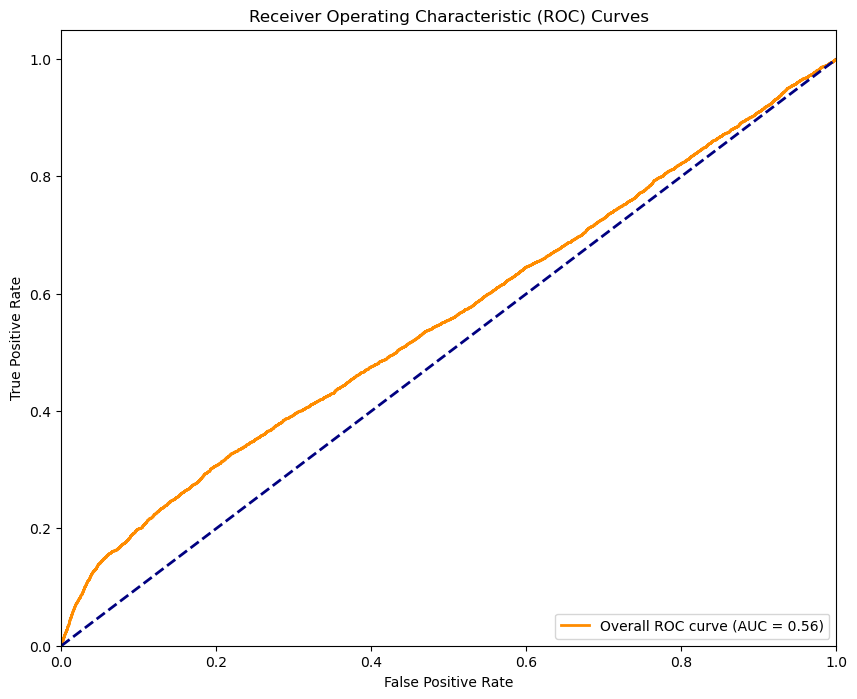

In [13]:
# Main execution
data_folder = "../datasets/UTS/NAB"

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        result = process_directory(sequence_length, stride, input_size, data_path, base_config, TCN, noise_scheduler)
        all_dir_results.append(result)

# Compute and plot overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

# Save results to CSV
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"per_directory_roc_results_{config.num_epochs}.csv"))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for res in all_dir_results:
    if res['dir'] == 'Overall':
        plt.plot(res['fpr'], res['tpr'], color='darkorange', lw=2, label=f"Overall (AUC = {res['roc_auc']:.2f})")
    else:
        plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_roc_curves_{config.num_epochs}.png"))
plt.close()

print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()

In [14]:
# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"one_b_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: nan
Median: nan
Min: nan
Max: nan
